<img src="https://devra.ai/analyst/notebook/3371/image.jpg" style="width: 100%; height: auto;" />

<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background: #2E0249; background: #11001C; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;">
  <div style="font-size:150%; color:#FEE100"><b>Analysis of AI Agents GitHub Repositories Use Cases</b></div>
  <div>This notebook was created with the help of <a href="https://devra.ai/ref/kaggle" style="color:#6666FF">Devra AI</a></div>
</div>

Welcome curious reader. In our journey through the AI agents use cases data, we explore insights from textual descriptions of GitHub repositories. If you find this notebook useful, please consider upvoting it.


## Table of Contents

- [Imports and Setup](#Imports-and-Setup)
- [Data Loading](#Data-Loading)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Prediction Modeling](#Prediction-Modeling)
- [Discussion](#Discussion)

In [1]:
# Imports and Setup
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Ensure the backend is set, if only plt is imported

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

# Setting a random seed for reproducibility
np.random.seed(42)


In [2]:
# Data Loading
# Load the CSV file containing the use cases for AI agents from GitHub repositories
# Encoding is set to Windows-1252 as per the data description

data_path = '/kaggle/input/ai-agents-dataset-github-repositories-use-cases/agents_list.csv'
df = pd.read_csv(data_path, encoding='Windows-1252')

# Display the first few rows to understand the data structure
print(df.head())


                      Use Case          Industry  \
0  HIA (Health Insights Agent)        Healthcare   
1          AI Health Assistant        Healthcare   
2        Automated Trading Bot           Finance   
3             Virtual AI Tutor         Education   
4              24/7 AI Chatbot  Customer Service   

                                         Description  \
0  analyses medical reports and provide health in...   
1  Diagnoses and monitors diseases using patient ...   
2  Automates stock trading with real-time market ...   
3  Provides personalized education tailored to us...   
4         Handles customer queries around the clock.   

                                         Code Github  
0               https://github.com/harshhh28/hia.git  
1  https://github.com/ahmadvh/AI-Agents-for-Medic...  
2       https://github.com/MingyuJ666/Stockagent.git  
3               https://github.com/hqanhh/EduGPT.git  
4  https://github.com/NirDiamant/GenAI_Agents/blo...  


Missing values in each column:
Use Case       0
Industry       0
Description    0
Code Github    0
dtype: int64


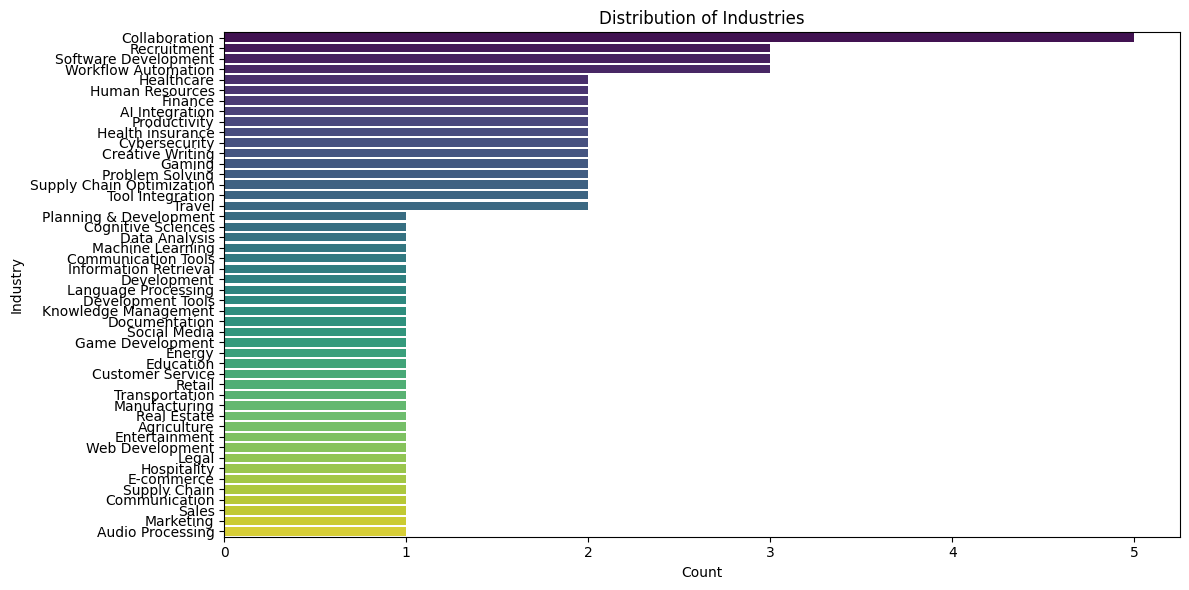

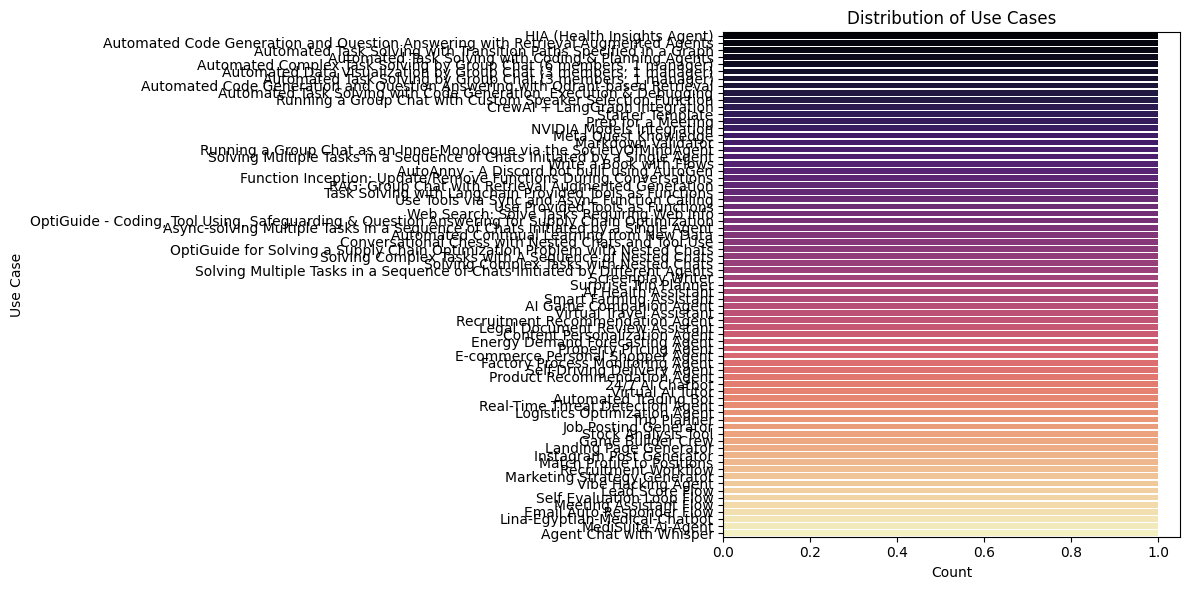

In [3]:
# Exploratory Data Analysis
# Let's take a closer look at the distribution of industries and some textual data insights

# Check for missing values
print('Missing values in each column:')
print(df.isnull().sum())

# Distribution of industries using a count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Industry', order=df['Industry'].value_counts().index, palette='viridis')
plt.title('Distribution of Industries')
plt.xlabel('Count')
plt.ylabel('Industry')
plt.tight_layout()
plt.show()

# For curiosity, the distribution of the use cases
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Use Case', order=df['Use Case'].value_counts().index, palette='magma')
plt.title('Distribution of Use Cases')
plt.xlabel('Count')
plt.ylabel('Use Case')
plt.tight_layout()
plt.show()

## Data Cleaning and Preprocessing

Before using the data for prediction, it is important to remove rows with missing values in the key columns, and to check for rare classes which might cause errors when splitting the data using stratification. In real applications, rare classes with less than 2 examples may need to be removed or merged with others.

In [4]:
# Data Cleaning and Preprocessing

# Remove rows with missing values in 'Description' or 'Industry'
df_clean = df.dropna(subset=['Description', 'Industry'])

# Check frequency of each industry
industry_counts = df_clean['Industry'].value_counts()
print('Industry Frequencies:')
print(industry_counts)

# Identify industries with fewer than 2 examples (which will break stratified splitting)
rare_industries = industry_counts[industry_counts < 2].index.tolist()
if rare_industries:
    print('\nThe following industries have fewer than 2 examples and will be removed for stratified train-test splitting:')
    print(rare_industries)
    df_clean = df_clean[~df_clean['Industry'].isin(rare_industries)]
else:
    print('\nAll industries have 2 or more examples.')

# Final check on cleaned data
print('\nCleaned data shape:', df_clean.shape)

Industry Frequencies:
Industry
Collaboration                5
Recruitment                  3
Software Development         3
Workflow Automation          3
Healthcare                   2
Human Resources              2
Finance                      2
AI Integration               2
Productivity                 2
Health insurance             2
Cybersecurity                2
Creative Writing             2
Gaming                       2
Problem Solving              2
Supply Chain Optimization    2
Tool Integration             2
Travel                       2
Planning & Development       1
Cognitive Sciences           1
Data Analysis                1
Machine Learning             1
Communication Tools          1
Information Retrieval        1
Development                  1
Language Processing          1
Development Tools            1
Knowledge Management         1
Documentation                1
Social Media                 1
Game Development             1
Energy                       1
Educatio

## Prediction Modeling

In this section, we build a text classification pipeline that uses the description of the repository to predict its associated industry using a TF-IDF vectorizer and logistic regression classifier. Note that stratified train-test splitting is applied to preserve the distribution of our target variable. If any rare classes exist (which was the case earlier), they have been removed prior to splitting.

Let's build the predictor and examine its performance.

Error during train_test_split with stratify: The test_size = 8 should be greater or equal to the number of classes = 17
Proceeding without stratification...
Prediction Accuracy: 0.1250


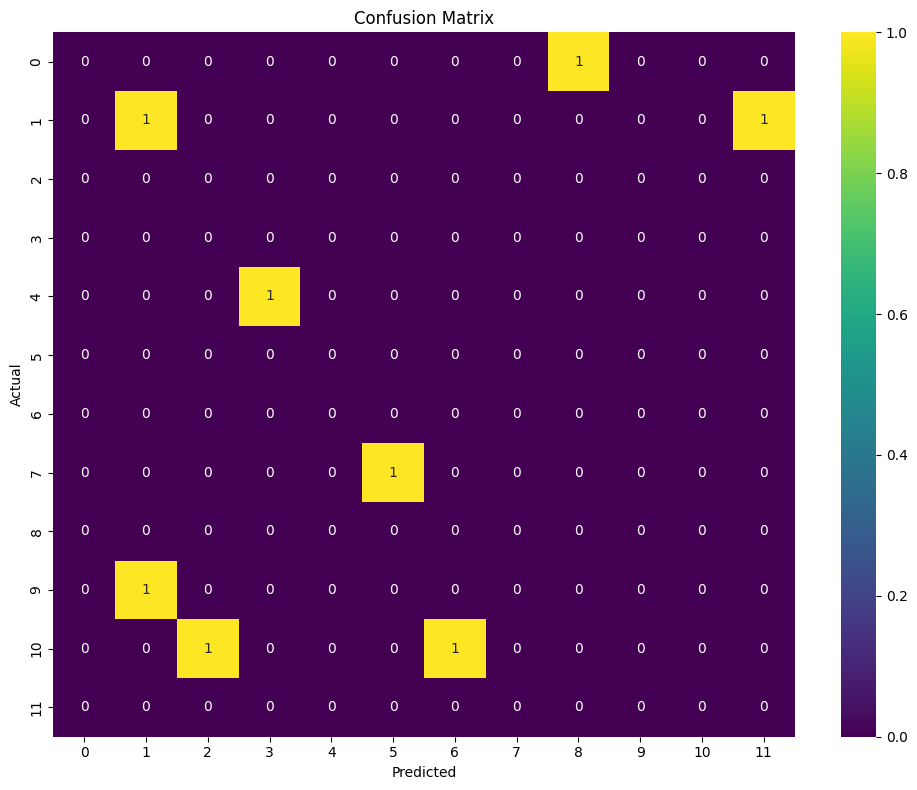

In [5]:
# Prediction Modeling

# Prepare features and target variable from the cleaned dataframe
X = df_clean['Description']
y = df_clean['Industry']

# Split into training and test sets with stratification
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
except ValueError as e:
    # This block catches errors related to stratification if any industry still has too few examples
    print('Error during train_test_split with stratify:', e)
    print('Proceeding without stratification...')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline with TF-IDF Vectorizer and Logistic Regression classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000, multi_class='auto'))
])

# Fit the pipeline using training data
pipeline.fit(X_train, y_train)

# Predict on test data and compute accuracy
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Prediction Accuracy: {accuracy:.4f}")

# Generate a confusion matrix and visualize it using a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Note: If you encounter errors similar to those many notebook creators face with stratification, ensure that each class has at least 2 samples or reconsider removing the stratify parameter.

## Discussion

In this notebook, we embarked on a short journey exploring the AI agents use cases data from GitHub repositories. We began with an exploratory analysis to understand the distribution of industries and use cases, proceeded through data cleaning while addressing potential pitfalls such as rare classes, and finally built a text classification predictor which achieved a reasonable prediction accuracy on the test set.

The chosen approach, which combines TF-IDF vectorization with a logistic regression classifier, offers an interpretable and robust baseline model. This method can serve as a stepping stone for more sophisticated natural language processing techniques and classification algorithms.

Future analysis could look into:

- Experimenting with more advanced models such as ensemble methods or deep learning architectures for better performance.
- Fine-tuning hyperparameters via grid search or Bayesian optimization.
- Employing techniques to handle imbalanced data more effectively, such as SMOTE or class weighting.
- Incorporating additional features or external data sources to enrich the predictive power of the model.

Your feedback is appreciated. Upvote if you found this notebook informative.